# A TUTORIAL ON BAYESIAN LINEAR REGRESSION WITH STAN

by Sebastian T. Glavind, May, 2020

In [1]:
import math
import numpy as np
import scipy.stats as ss
import pandas as pd
import pystan
import pickle
# import arviz
from matplotlib import pyplot as plt

%matplotlib inline
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

## The model

In the simplest case of linear regression, sometimes called ordinary linear regression, the scalar output $y$ is assumed to be a linear combination of the inputs $\mathbf{x}$, and the observation errors follow a Gaussian white noise distribution, thus

$$ y | \mathbf{w}, \sigma, \mathbf{x} \sim \mathcal{N}(w_0 + \sum_{m=1}^{M-1} w_m x_m, \sigma^2) = \mathcal{N}(\mathbf{w}^T \mathbf{x}, \sigma^2), $$

where we have augmented the input vector $\mathbf{x}$ with an additional first element, which is always 1, thus $\mathbf{x} = (1, x_1, x_2, ..., x_{M-1})$.

If we now consider a training data set $\mathcal{D}=\{ \mathbf{x}[n], y[n] \}_{n=1}^N = \{ \mathbf{X}, \mathbf{y} \}$, where $\mathbf{X}$ is a $ N \times M $ design matrix and $\mathbf{y}$ is a column vector of the corresponding output observations, the joint likelihood of the training data may be written:

$$ \mathbf{y} | \mathbf{w}, \sigma, \mathbf{X} \sim \prod_{n=1}^N \mathcal{N}(\mathbf{w}^T \mathbf{x}[n], \sigma^2) = \mathcal{N}(\mathbf{X}\mathbf{w},\sigma^2\mathbf{I}), $$

where $\mathbf{I}$ is an $ N \times N $ identity matrix.

In a Bayesian model, apart from the likelihood function, we also need to assign priors to the model parameters. In this tutorial, we will consider to sets of prior specification resulting in two models, namely

### Model 1
In this model, we will consider the following simple, non-informative priors of the parameters:

$$ p(\mathbf{w}) = \mathcal{N}(\mathbf{w} | \boldsymbol0, 10^2 \mathbf{I} ) $$

$$ p(\sigma) = \text{half-cauchy}(0,5^2), $$

see e.g. https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations.


### Model 2

In this model, we will consider the following priors of the parameters:
$$ p(\mathbf{w},\beta|\alpha) = \mathcal{N}(\mathbf{w} | 0, (\beta \mathbf{A})^{-1} ) \text{Gam}(\beta | a_0, b_0 ) $$
$$ p(\mathbf{\alpha}) = \prod_{m=1} \text{Gam}(\alpha_m|c_0,d_0), $$

where we consider the precision instead of the noise variance, thus

$$ \alpha_m = \frac{1}{\sigma_{w,m}^2} \quad \text{and} \quad \beta = \frac{1}{\sigma^2}, $$

see e.g. Drugowitsch(2013). Note that Drugowitsch(2013) uses $\tau$ for the output precision. 

***
Drugowitsch, J, ''Variational Bayesian inference for linear and logistic regression'', 2013, (avaliable at https://arxiv.org/pdf/1310.5438.pdf)
***

## Sample data

### Generating process

In [2]:
w0_true = 4
w1_true = 8
sigma_true = 2

In [3]:
def generate_training_data(x, w0, w1, sigma):
    n = len(x)
    error = np.random.normal(loc=0, scale=sigma, size=n)
    return( w0 + w1*x + error )

### Training data

In [4]:
x_tr = np.arange(start=-1, stop=1, step=0.1)
np.random.seed(10) # good seed
y_tr = generate_training_data(x=x_tr, w0 = w0_true, w1 = w1_true, sigma = sigma_true)

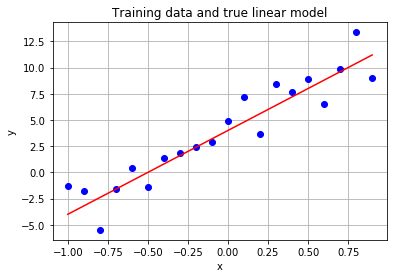

In [5]:
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr,(w0_true + w1_true * x_tr),'-r');
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training data and true linear model')
plt.grid()

In [6]:
XX = np.vstack((np.ones(len(x_tr)), x_tr)).T # design matrix (convention Bishop(2006))
nX_tr, mX_tr = XX.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

### Test data

In [7]:
x_te = np.arange(start=-1.25, stop=1.25, step=0.1)
XX_te = np.vstack((np.ones(len(x_te)), x_te)).T # design matrix (convention Bishop(2006))
nX_te, mX_te = XX_te.shape # - np.array([0, 1]); # data dimensions are defined as actual features ;)

## Stan

In [8]:
# data in stan formate
x_stan = np.ndarray.tolist(XX)
y_stan = np.ndarray.tolist(y_tr)

stan_dat = {'N': nX_tr,
            'K': mX_tr,
            'x': x_stan,
            'y': y_stan}

### Model 1

In [9]:
stan_code1 = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of inputs
  matrix[N, K] x;   // input matrix
  vector[N] y;      // output vector
}
parameters {
  vector[K] w;       // coefficients for inputs
  real<lower=0> sigma;  // error scale
}
model {
  for(k in 1:K)
    w[k] ~ normal(0, 10); // prior for coefficients
  sigma ~ cauchy(0, 5); // prior for error scale
  y ~ normal(x * w, sigma);  // likelihood
}
"""

In [10]:
# compile model
sm1 = pystan.StanModel(model_code=stan_code1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53902d24c60c98535f43f1e5b9d1fc5e NOW.


In [11]:
# fit model
fit1 = sm1.sampling(data=stan_dat, iter=1000, chains=4, seed=42) 

print(fit1)

Inference for Stan model: anon_model_53902d24c60c98535f43f1e5b9d1fc5e.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w[1]    4.21  9.2e-3   0.41   3.42   3.94    4.2   4.48   5.02   1947    1.0
w[2]    7.78    0.02   0.76   6.28   7.31   7.79   8.25    9.3   1822    1.0
sigma   1.87  8.5e-3   0.33   1.35   1.64   1.81   2.05   2.64   1481    1.0
lp__  -21.79    0.05   1.32 -25.04 -22.41 -21.42 -20.84 -20.34    722    1.0

Samples were drawn using NUTS at Wed May 27 13:56:08 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [12]:
# extract samples
samp1 = fit1.extract(permuted=True)
w_samp1 = samp1['w']
sigma_samp1 = samp1['sigma']

In [13]:
# sample statistics
f_pred1 = np.dot(w_samp1, XX_te.T)
y_pred1 = f_pred1 + np.random.normal(scale=sigma_samp1).reshape([-1,1])

mu_pred_f1 = np.mean(f_pred1,axis=0)
cf_pred_f1 = np.quantile(f_pred1,q=[0.025, 0.975],axis=0)
cf_pred_y1 = np.quantile(y_pred1,q=[0.025, 0.975],axis=0)

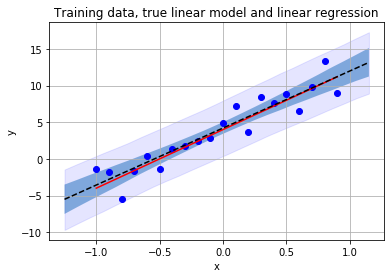

In [14]:
# plot regression model
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr, (w0_true + w1_true * x_tr),'-r');
plt.plot(x_te, mu_pred_f1,'--k');
plt.fill_between(x=x_te, y1=cf_pred_f1[0,:], y2=cf_pred_f1[1,:], alpha=0.5);
plt.fill_between(x=x_te, y1=cf_pred_y1[0,:], y2=cf_pred_y1[1,:], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();

### Model 2

Note that we could consider to reparameterize the probabilistic formulation for $\mathbf{w}$ as

$$ \mathbf{w} = \mathbf{L}_w  \boldsymbol\eta_w$$

where $(\beta \mathbf{A})^{-1} = \mathbf{L}_w^T \mathbf{L}_w$, and $\boldsymbol\eta_w = \mathcal{N}(\boldsymbol0, \mathbf{I})$. This formulation is generally easier for stan to sample from, as the underlaying stochastic variables $\boldsymbol\eta_w$ are independent, see e.g. Gelman et al(2013).

***
Gelman, Andrew, et al. Bayesian data analysis. CRC press, 2013.
***

In [15]:
stan_code2 = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of inputs
  matrix[N, K] x;   // input matrix
  vector[N] y;      // output vector
}
parameters {
  vector[K] w;              // coefficients for inputs
  vector<lower=0>[K] alpha; // ARD vector (precision)
  real<lower=0> beta;       // error scale (precision)
}
model {
  for(k in 1:K)
    w[k] ~ normal(0, (beta*alpha[k])^(-0.5)); // prior for coefficients
  alpha ~ gamma(2, 2); // ARD vector
  beta ~ gamma(2, 2); // prior for error scale
  y ~ normal(x * w, beta^(-0.5));  // likelihood
}
"""

In [16]:
sm2 = pystan.StanModel(model_code=stan_code2) # compile model

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b30deeae169b7544706f5007aa369662 NOW.


In [17]:
control = {}
control['adapt_delta'] = 0.95
control['max_treedepth'] = 20

fit2 = sm2.sampling(data=stan_dat, iter=1000, chains=4, seed=42, control=control) # fit model

print(fit2)

Inference for Stan model: anon_model_b30deeae169b7544706f5007aa369662.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
w[1]       4.11    0.01   0.43   3.22   3.83   4.12    4.4   4.93   1577    1.0
w[2]       7.53    0.02   0.76   6.07   7.05   7.52    8.0   9.05   1909    1.0
alpha[1]   0.57  8.3e-3   0.38   0.08   0.29   0.49   0.75   1.56   2107    1.0
alpha[2]   0.26  5.3e-3    0.2   0.03   0.12   0.21   0.34   0.78   1446    1.0
beta       0.29  2.6e-3   0.09   0.14   0.22   0.28   0.35    0.5   1312    1.0
lp__     -37.44    0.06   1.74 -41.69 -38.31 -37.09 -36.15 -35.24    820    1.0

Samples were drawn using NUTS at Wed May 27 13:56:48 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [22]:
# extract samples
samp2 = fit2.extract(permuted=True)
w_samp2 = samp2['w']
beta_samp2 = samp2['beta']

print('Average standard deviation:', np.mean(beta_samp2)**(-0.5))

Average standard deviation: 1.856724838444811


In [19]:
# sample statistics
f_pred2 = np.dot(w_samp2, XX_te.T)
y_pred2 = f_pred2 + np.random.normal(scale=beta_samp2**(-0.5)).reshape([-1,1])

mu_pred_f2 = np.mean(f_pred2,axis=0)
cf_pred_f2 = np.quantile(f_pred2,q=[0.025, 0.975],axis=0)
cf_pred_y2 = np.quantile(y_pred2,q=[0.025, 0.975],axis=0)

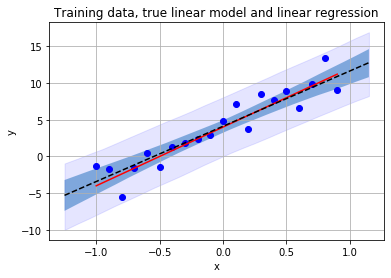

In [20]:
# plot regression model
plt.plot(x_tr, y_tr,'ob');
plt.plot(x_tr, (w0_true + w1_true * x_tr),'-r');
plt.plot(x_te, mu_pred_f2,'--k');
plt.fill_between(x=x_te, y1=cf_pred_f2[0,:], y2=cf_pred_f2[1,:], alpha=0.5);
plt.fill_between(x=x_te, y1=cf_pred_y2[0,:], y2=cf_pred_y2[1,:], alpha=0.1, color='blue');
plt.xlabel('x');
plt.ylabel('y');
plt.title('Training data, true linear model and linear regression');
plt.grid();